# i. Pendahuluan

<h4>Dataset yang digunakan : </h4> 

Dataset yang digunakan adalah data review user terhadap suatu bisnis lokal di aplikasi Yelp.

<h4>Objective : </h4>

Project ini bertujuan untuk memprediksi apakah review seseorang pada aplikasi Yelp termasuk sentimen positif atau negatif.

<h4>Link Dataset:</h4> 

https://www.kaggle.com/datasets/thedevastator/yelp-reviews-sentiment-dataset

<h4>Link Website Model Deployment:</h4> 

https://huggingface.co/spaces/AnandaKhairurriza/P2Milestone2


# ii. Import Libraries

In [2]:
# Agar reset seed dapat bekerja
import os

import numpy as np # Untuk mengolah array
import pandas as pd # Untuk mengolah data tabular
from sklearn.model_selection import train_test_split # Untuk memisahkan train set dan test set
from sklearn.feature_extraction.text import CountVectorizer # Untuk vektorisasi teks
import random

# Untuk mengolah teks
import string
import re
from wordcloud import WordCloud

# Untuk visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns

# Untuk text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Untuk merancang model
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, Input, Dropout, BatchNormalization, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# Untuk evaluasi model
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix

# Untuk mendownload kosakata
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# iii. Data Loading
Pada tahap ini dilakukan penyiapan dataset (load, periksa ukuran) sebelum dilakukan analisis dan pengolahan.

In [2]:
# Load data csv
df = pd.read_csv("h8dsft_P2M2_Ananda_Khairurriza.csv")

In [3]:
# Tampilkan 10 data awal
df.head(10)

,text,label
0,"Contrary to other reviews, I have zero complai...",1
1,Last summer I had an appointment to get new ti...,0
2,"Friendly staff, same starbucks fair you get an...",1
3,The food is good. Unfortunately the service is...,0
4,Even when we didn't have a car Filene's Baseme...,1
5,"Picture Billy Joel's \""""Piano Man\"""" DOUBLED m...",1
6,Mediocre service. COLD food! Our food waited s...,0
7,Ok! Let me tell you about my bad experience fi...,0
8,I used to love D&B when it first opened in the...,0
9,"Like any Barnes & Noble, it has a nice comfy c...",1


In [4]:
# Tampilkan 10 data akhir
df.tail(10)

,text,label
37990,This was my first Yelp Elite event and my firs...,1
37991,I'm in love with this adorable little shop! It...,1
37992,'Twas the week before Christmas and all throug...,1
37993,This place was just okay for me. It was nothin...,0
37994,Extremely disappointing and frustrating experi...,0
37995,If I could give 0...I would. Don't do it.,0
37996,Items Selected:\nChocolate Cinnamon Horn\nSmal...,1
37997,Expensive lunch meals. Fried pickles were goo...,0
37998,Highly overpriced and food was cold. Our waitr...,0
37999,I have been using this company for 11 months. ...,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38000 entries, 0 to 37999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    38000 non-null  object
 1   label   38000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 593.9+ KB


Berdasarkan informasi, pada dataset yang digunakan terdapat 2 kolom dan 38000 data. Kolom text berjenis string dan kolom label berjenis integer. Selain itu tidak ada missing value pada dataset ini.

In [6]:
# Cek data duplikat
check = df.duplicated()
check.value_counts()

False    38000
dtype: int64

Dari hasil pencarian data duplikat, tidak ada data duplikat pada dataset (semua datanya False)

# iv. Text Preprocessing

Text Preprocessing merupakan tahap untuk mempersiapkan data teks yang tidak terstruktur menjadi data yang dapat diolah oleh model. Berikut langkah-langkah yang dilakukan pada text preprocessing:
<ol>
    <li>Case Folding (Convert huruf ke lowercase)</li>
    <li>Tokenizing (Menghilangkan karakter yang tidak diperlukan)</li>
    <li>Remove stopword (Pembuangan stopword)</li>
    <li>Lemmatization (Pengubahan menjadi kata dasar)</li>
</ol>

In [7]:
# Copy dataset ke variabel baru
df_copy = df.copy()

In [8]:
# Mengambil salah satu document/teks pada dataset
txt = df_copy.text[10]
print(txt)

Meh, I've experienced better is an understatement.\n\nFriday's is like the \""fine dining chain\"" for every yinzer in Pittsburgh...\n\n1.  When we were seated, it was quick which was a surprise.  Somehow this restaurant gets packed and I never understand why.  I was happy about that.\n2.  I ordered one of their \""skinny margaritas\"", blackberry to be exact.  It was a nice size, however, at $6.00/pop, that was half of my food bill.\n3.  The waitress started off attentive, but after our food came out she was gone.  I ordered a turkey burger with pickle and mustard.  Loaded mashed potato on the side because I wanted heartburn ha!\n4.  Food came.  My burger had lettuce on it only.  Waitress was supposed to go and get our next round of drinks.  I had to wait to ask for my pickle.\n5.  The loaded potatoes were more like rubber than potatoes and not what I was expecting.  Disappointment.\n6.  The waitress then went into oblivion and only returned with our check.  \n\nNever again will I eat

### Case Folding (Convert huruf ke lowercase)

Ditahap ini akan dilakukan standarisasi agar kata yang memiliki huruf uppercase maknanya sama dengan lowercase.

In [9]:
# Ubah teks ke lowercase
txt_low = txt.lower()
txt_low

'meh, i\'ve experienced better is an understatement.\\n\\nfriday\'s is like the \\""fine dining chain\\"" for every yinzer in pittsburgh...\\n\\n1.  when we were seated, it was quick which was a surprise.  somehow this restaurant gets packed and i never understand why.  i was happy about that.\\n2.  i ordered one of their \\""skinny margaritas\\"", blackberry to be exact.  it was a nice size, however, at $6.00/pop, that was half of my food bill.\\n3.  the waitress started off attentive, but after our food came out she was gone.  i ordered a turkey burger with pickle and mustard.  loaded mashed potato on the side because i wanted heartburn ha!\\n4.  food came.  my burger had lettuce on it only.  waitress was supposed to go and get our next round of drinks.  i had to wait to ask for my pickle.\\n5.  the loaded potatoes were more like rubber than potatoes and not what i was expecting.  disappointment.\\n6.  the waitress then went into oblivion and only returned with our check.  \\n\\nneve

### Tokenizing (Menghilangkan karakter yang tidak diperlukan)

Pada tahap ini akan dilakukan penghilangan karakter-karakter yang dianggap tidak memiliki makna dan tidak mempengaruhi pemrosesan teks (hashtag, mention, link website, dsb).

In [10]:
# Menghilangkan link
txt_token = re.sub(r"http\S+", " ", txt_low)
txt_token = re.sub(r"www.\S+", " ", txt_token)

# Menghilangkan karakter \n
txt_token = re.sub(r"\\n", " ", txt_token)

# Menghilangkan mention (@teks)
txt_token = re.sub("@[A-Za-z0-9_]+", " ", txt_token) 

# Menghilangkan hashtag (#teks)
txt_token = re.sub("#[A-Za-z0-9_]+", " ", txt_token)

# Menghilangkan yang karakter selain huruf
txt_token = re.sub("[^A-Za-z\s']", " ", txt_token)

# Merapihkan space kosong
txt_token = ' '.join(txt_token.split())

txt_token

"meh i've experienced better is an understatement friday's is like the fine dining chain for every yinzer in pittsburgh when we were seated it was quick which was a surprise somehow this restaurant gets packed and i never understand why i was happy about that i ordered one of their skinny margaritas blackberry to be exact it was a nice size however at pop that was half of my food bill the waitress started off attentive but after our food came out she was gone i ordered a turkey burger with pickle and mustard loaded mashed potato on the side because i wanted heartburn ha food came my burger had lettuce on it only waitress was supposed to go and get our next round of drinks i had to wait to ask for my pickle the loaded potatoes were more like rubber than potatoes and not what i was expecting disappointment the waitress then went into oblivion and only returned with our check never again will i eat at friday's i will however go should a happy hour arise"

### Remove stopword (Pembuangan stopword)

Tahap ini dilakukan untuk menghapus stopwords pada document. Stopwords merupakan kata umum yang sering muncul tetapi tidak mempunyai makna (by, in, were). Kata yang akan dibuang berdasarkan list stopword yang tersedia di library nltk.

In [11]:
# Pembuangan stopword
list_stopwords = list(set(stopwords.words('english')))
tokens = word_tokenize(txt_token)
txt_stopwords = ' '.join([word for word in tokens if word not in list_stopwords])
txt_stopwords

"meh 've experienced better understatement friday 's like fine dining chain every yinzer pittsburgh seated quick surprise somehow restaurant gets packed never understand happy ordered one skinny margaritas blackberry exact nice size however pop half food bill waitress started attentive food came gone ordered turkey burger pickle mustard loaded mashed potato side wanted heartburn ha food came burger lettuce waitress supposed go get next round drinks wait ask pickle loaded potatoes like rubber potatoes expecting disappointment waitress went oblivion returned check never eat friday 's however go happy hour arise"

### Tokenizing 2

Pada tokenizing kedua dilakukan pembuangan karakter yang tidak bermakna dan tanda baca. Karena sebelumnya tanda baca digunakan untuk seleksi kata pada stopword (contohnya kata don't terdapat tanda kutip. Sedangkan pada stopword dibutuhkan kata don't dengan tanda kutip)

In [12]:
# Menghilangkan token kecil (1 - 2 huruf)
shortword = re.compile(r'\W*\b\w{1,2}\b')
txt_token = shortword.sub(' ', txt_stopwords)

# Menghilangkan tanda baca
txt_token = txt_token.translate(str.maketrans('', '', string.punctuation))

# Merapihkan space kosong
txt_token = ' '.join(txt_token.split())

txt_token

'meh experienced better understatement friday like fine dining chain every yinzer pittsburgh seated quick surprise somehow restaurant gets packed never understand happy ordered one skinny margaritas blackberry exact nice size however pop half food bill waitress started attentive food came gone ordered turkey burger pickle mustard loaded mashed potato side wanted heartburn food came burger lettuce waitress supposed get next round drinks wait ask pickle loaded potatoes like rubber potatoes expecting disappointment waitress went oblivion returned check never eat friday however happy hour arise'

### Lemmatization (Pengubahan menjadi kata dasar)

Lemmatization merupakan tahap dimana mengubah kata menjadi kata dasarnya (running = run atau leaves = leaf). Lemmatization disini menggunakan Word Net Lemmatizer.

In [13]:
# Lemmatization dengan Word Net Lemmatizer
lem = WordNetLemmatizer()
tokens = word_tokenize(txt_token)
lemma_list = []
for n in tokens:
    res = lem.lemmatize(n)
    lemma_list.append(res)

txt_lem = ' '.join([word for word in lemma_list])
txt_lem

'meh experienced better understatement friday like fine dining chain every yinzer pittsburgh seated quick surprise somehow restaurant get packed never understand happy ordered one skinny margarita blackberry exact nice size however pop half food bill waitress started attentive food came gone ordered turkey burger pickle mustard loaded mashed potato side wanted heartburn food came burger lettuce waitress supposed get next round drink wait ask pickle loaded potato like rubber potato expecting disappointment waitress went oblivion returned check never eat friday however happy hour arise'

### Apply text preprocessing to all documents

Dari langkah-langkah preprocessing yang telah dilakukan akan diaplikasikan ke semua document.

In [15]:
# Buat function text preprocessing
def txt_preprocessing(datatext):
    # Ubah teks ke lowercase
    datatext = datatext.lower()

    # Menghilangkan link
    datatext = re.sub(r"http\S+", " ", datatext)
    datatext = re.sub(r"www.\S+", " ", datatext)

    # Menghilangkan karakter \n
    datatext = re.sub(r"\\n", " ", datatext)

    # Menghilangkan mention (@teks)
    datatext = re.sub("@[A-Za-z0-9_]+", " ", datatext) 

    # Menghilangkan hashtag (#teks)
    datatext = re.sub("#[A-Za-z0-9_]+", " ", datatext)

    # Menghilangkan yang karakter selain huruf
    datatext = re.sub("[^A-Za-z\s']", " ", datatext)

    # Merapihkan space kosong
    datatext = ' '.join(datatext.split())

    # Pembuangan stopword
    tokens = word_tokenize(datatext)
    datatext = ' '.join([word for word in tokens if word not in list_stopwords])

    # Menghilangkan token kecil (1 - 2 huruf)
    shortword = re.compile(r'\W*\b\w{1,2}\b')
    datatext = shortword.sub(' ', datatext)

    # Menghilangkan tanda baca
    datatext = datatext.translate(str.maketrans('', '', string.punctuation))

    # Merapihkan space kosong
    datatext = ' '.join(datatext.split())

    # Lemmatizing
    tokens = word_tokenize(datatext)
    lemma_list = []
    for n in tokens:
      res = lem.lemmatize(n)
      lemma_list.append(res)

    datatext = ' '.join([word for word in lemma_list])

    return datatext

In [16]:
# Mengaplikasikan preprocessing ke semua documents
df_copy['text_preprocessed'] = df_copy['text'].apply(lambda x: txt_preprocessing(x))
df_copy

,text,label,text_preprocessed
0,"Contrary to other reviews, I have zero complai...",1,contrary review zero complaint service price g...
1,Last summer I had an appointment to get new ti...,0,last summer appointment get new tire wait supe...
2,"Friendly staff, same starbucks fair you get an...",1,friendly staff starbucks fair get anywhere els...
3,The food is good. Unfortunately the service is...,0,food good unfortunately service hit miss main ...
4,Even when we didn't have a car Filene's Baseme...,1,even car filene basement worth bus trip waterf...
...,...,...,...
37995,If I could give 0...I would. Don't do it.,0,could give would
37996,Items Selected:\nChocolate Cinnamon Horn\nSmal...,1,item selected chocolate cinnamon horn small ci...
37997,Expensive lunch meals. Fried pickles were goo...,0,expensive lunch meal fried pickle good waitres...
37998,Highly overpriced and food was cold. Our waitr...,0,highly overpriced food cold waitress seemed co...


# v. Exploratory Data Analysis (EDA)
Pada tahap ini dilakukan eksplorasi terhadap dataset untuk mengetahui informasi data lebih detail.

In [43]:
# Copy dataframe ke variabel baru untuk EDA
df_eda = df_copy.copy()

### Perbandingan sentiment

([<matplotlib.patches.Wedge at 0x7f6162075ac0>,
 [Text(6.735557395310444e-17, 1.1, '1'),
  Text(-2.0206672185931328e-16, -1.1, '0')],
 [Text(3.6739403974420595e-17, 0.6, '50.0%\n(19000)'),
  Text(-1.1021821192326178e-16, -0.6, '50.0%\n(19000)')])

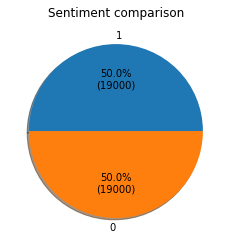

In [44]:
def fmt(x):
    return "{:.1f}%\n({:.0f})".format(x, len(df_eda)*x/100)

de_cmp = df_eda["label"].value_counts()
plt.title("Sentiment comparison")
plt.pie(de_cmp, labels=de_cmp.index, shadow = True, autopct=fmt)

Berdasarkan pie chart, perbandingan jumlah sentimen positif dan negatif benar-benar seimbang. Yaitu masing-masing berjumlah 19.000 data, artinya setengah customer bersentimen positif pada suatu bisnis lokal di Yelp dan setengah sisanya bersentimen negatif pada suatu bisnis lokal di Yelp.

### Jumlah kata terbanyak pada sentimen positif

In [45]:
# Ubah document menjadi vektor
vectorize_eda = CountVectorizer()
cv = vectorize_eda.fit_transform(df_eda[df_eda["label"] == 1]["text_preprocessed"])
cv_df = pd.DataFrame(cv.toarray(), columns=vectorize_eda.get_feature_names_out())

In [46]:
# Ubah ke dataframe
n_pos = cv_df.sum().sort_values(ascending=False)
n_pos_df = pd.DataFrame(n_pos, columns=["count"])
n_pos_df.reset_index(inplace=True)

In [47]:
# Inisialisasi wordcloud
pos_txt = ' '.join([word for word in n_pos_df["index"]])
wordcloud = WordCloud(width=1600, height=800, max_font_size=200, background_color='white')
wordcloud.generate(pos_txt)

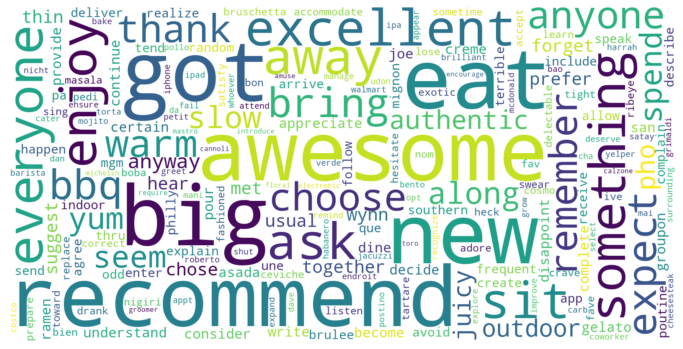

In [48]:
# Tampilkan wordcloud
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Sebagian besar, kata yang sering muncul pada sentimen positif adalah awesome, excellent, new, recommend, dsb. Artinya sebagian besar user yang bersentimen positif memiliki kepuasan dan menyukai kepada suatu bisnis lokal di Yelp. Kepuasan user dapat dari produk (makanan, minuman, barang lain) maupun layanan dari bisnis lokal tersebut. Selaintitu, karena terdapat kata "recommend", dapat dikatakan sebagian besar user merekomendasikan bisnis lokal tersebut kepada user lain.

Kata eat dan big dirasa cukup ambigu mengapa kata tersebut paling sering muncul pada sentimen positif. Selanjutnya akan dilakukan analisis mengapa kata tersebut dapat muncul.

#### Analisis token eat

In [123]:
# Ambil document yang mengandung token eat
eda_eat = df_eda[(df_eda['text_preprocessed'].str.contains('eat')) & (df_eda['label'] == 1)]["text_preprocessed"]
eda_eat.reset_index(drop=True, inplace=True)

'shelter fantastic generally good friendly people staff cat dog appear treated least well one might expect adopted one cat establishment return next day spayed free great reason get five star desk clerk completely forgot cat left waiting chatted cell phone friend remembered walking smoke saw sitting lobby'

In [126]:
eda_eat[0] # Ambil random document

'picture billy joel piano man doubled mixed beer rowdy crowd comedy welcome sing sing unique musical experience found homestead looking grab bite eat beer come serving food brew rock bottom brewery sing sing keep tummy full listen two amazingly talented pianist take musical request play anything like tip course wanting hear britney spear toto duran duran yep play new old crowd make show make sure come ready good time crowd dead harder guy get reaction wanting fun great time perfect place birthday party especially want embarrass friend guy bring piano perform little ditty good sport get coveted sing sing bumper sticker would want dueling piano brew time shut sing sing'

In [127]:
eda_eat[10] # Ambil random document

'gem place shadyside place like make miss living food outstanding first time wanted little bit appetizer becky salad special eve smoked salmon crostini creme fresh clam dish forgot name best tomatoe white wine could drunk bowl broth becky salad lemon dressing world delicious could drunk good usually fan walnut salad crumbled goat cheese made forget dislike ate happily good pairing special night opted sharing lamb shank reduced red wine sauce simple veggie small veggie selection american standard half russet potato slither zucchini stem green onion star afterall lamb meduim perfect ordered would care dessert ramon waiter fabulous asked round begin coffee chocolate mousse whip cream beauty version creme brulee thought hint peanut butter sure regardless divine place busy feel rushed unlike place service great atmoshphere quaint definitely neighbourhood cafe alot repeat clientele gathered shall return finally end note cafe zinho byob bring favourite bottle magnum vino take cash personal ch

In [128]:
eda_eat[15] # Ambil random document

'great shop watched make waffle come right shop delish tried salted caramel surprised find little chocolate covered caramel inside yum'

Sentimen tersebut merujuk kepada review dari sebuah restoran/toko makanan. Maka sebagian besar bisnis restoran banyak direview oleh user dengan sentimen yang positif.

#### Analisis token big

In [131]:
# Ambil document yang mengandung token big
eda_big = df_eda[(df_eda['text_preprocessed'].str.contains('big')) & (df_eda['label'] == 1)]["text_preprocessed"]
eda_big.reset_index(drop=True, inplace=True)

In [133]:
eda_big[3] # Ambil random document

'went first time saturday night try famous giant fish sandwich arrived impressed fish even bigger expected batter perfect also beer menu lengthy serve beer almost every corner world thought trying something new turn homesick good old pennsylvania beer roland definitely cool place book back'

In [138]:
eda_big[16] # Ambil random document

'friend went last night bombay grille started samosa ordered boy good choice filling come two big piece ordered chicken palak quite tasty little spicy taste next time note self order luckily waiter prompt refilling drink garlic naan sooo yummy eat dinner sauce chicken palak wish place minute away home'

In [141]:
eda_big[28] # Ambil random document

'enjoyed big unit hot dog actually delicious back whenever arizona waitress nice'

Kata big disini merepresentasikan suatu produk yang besar, maka sebagian besar review user bersentimen positif terhadap produk yang besar.

### Jumlah kata terbanyak pada sentimen negatif

In [49]:
# Ubah document menjadi vektor
vectorize_eda_2 = CountVectorizer()
cv_2 = vectorize_eda_2.fit_transform(df_eda[df_eda["label"] == 0]["text_preprocessed"])
cv_df_2 = pd.DataFrame(cv_2.toarray(), columns=vectorize_eda_2.get_feature_names_out())

In [50]:
# Ubah ke dataframe
n_neg = cv_df_2.sum().sort_values(ascending=False)
n_neg_df = pd.DataFrame(n_neg, columns=["count"])
n_neg_df.reset_index(inplace=True)

In [51]:
# Inisialisasi wordcloud
neg_txt = ' '.join([word for word in n_neg_df["index"]])
wordcloud = WordCloud(width=1600, height=800, max_font_size=200, background_color='white')
wordcloud.generate(neg_txt)

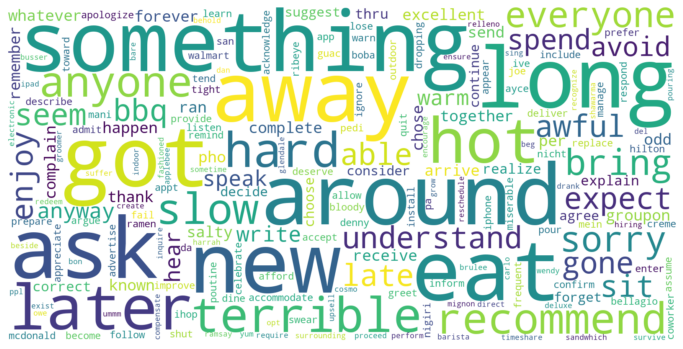

In [52]:
# Tampilkan wordcloud
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Sebagian besar, kata yang sering muncul pada sentimen negatif adalah long, terrible, hard, around, hot, dsb. Artinya sebagian besar user yang bersentimen negatif tidak puas terhadap suatu bisnis lokal di Yelp. Kemungkinan besar terjadinya sentimen negatif adalah user tidak menyukai pelayanan maupun produk (makanan, minuman, barang lain) dari bisnis lokal tersebut. Tetapi terdapat kata "new" termasuk kata yang sering muncul pada sentimen negatif. Selanjutnya akan dilakukan analisis mengapa hal itu dapat terjadi karena berdasarkan asumsi umumnya kata new/baru termasuk kedalam sentimen positif.

In [103]:
# Ambil document yang mengandung token new
eda_new = df_eda[(df_eda['text_preprocessed'].str.contains('new')) & (df_eda['label'] == 0)]["text_preprocessed"]
eda_new.reset_index(drop=True, inplace=True)
eda_new[15] # Ambil random document

'since return pittsburgh new elbow room several time food always decent location walnut convenient neighborhood shopping today went late lunch honestly people restaurant took forever food arrive table could attributed fact eating somewhere lunch dinner sufficiently staffed know beloved happy always enormous fish sandwich reuben sandwich okay corned beef pretty chewy probably gotten salad hoping caught bad afternoon'

Maksud new disini adalah seseorang yang mengeluh terhadap sesuatu yang baru. Sehingga konteks new disini termasuk sentimen yang negatif.

# vi. Tokenization & Word Embedding

### Train test set split

In [17]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(df_copy.text_preprocessed, df_copy.label, test_size=0.2, random_state=7, stratify=df_copy.label)

print("Train Size : ", X_train.shape[0])
print("Test Size : ", X_test.shape[0])

Train Size :  30400
Test Size :  7600


Hasil proses diatas adalah hasil split antara train dan test set. Dimana train set berjumlah 30400 document (80% dari corpus) dan test set berjumlah 7600 document (20% dari corpus). Selanjutnya akan dilakukan pencarian jumlah vocab dan panjang maksimal token dalam document untuk dibutuhkan pada embedding.

In [18]:
# Mencari jumlah vocab dan jumlah maksimum token dengan Count Vectorizer
Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_test_vec = Vectorize.transform(X_test)

X_train_vec

<30400x43204 sparse matrix of type '<class 'numpy.int64'>'
	with 1596294 stored elements in Compressed Sparse Row format>

Dari corpus test set, terdapat 1,313,401,600 values dan sebanyak 1596294 values yang tidak nol.

In [19]:
# Menampilkan jumlah vocab dan jumlah maksimum token
n_vocab = len(Vectorize.vocabulary_.keys())
max_token = max([len(i.split(" ")) for i in X_train])

print("Jumlah vocab : ", n_vocab, "vocab")
print("Panjang maksimum kalimat : ", max_token, "token")

Jumlah vocab :  43204 vocab
Panjang maksimum kalimat :  486 token


Dari hasil pencarian, didapatkan jumlah vocab pada corpus adalah 43.204 vocab. Dan panjang maksimal token pada satu dokumen adalah 486 token.

### Text Vectorization

Text vectorization merupakan proses perubahan teks pada document menjadi sebuah vektor. Nilai vektor berdasarkan urutan frekuensi kemunculan vocab tersebut (semakin kecil nilai pada vektor maka semakin sering vocab tersebut muncul di corpus).

In [20]:
# Text Vectorization
text_vectorization = TextVectorization(max_tokens=n_vocab, standardize="lower_and_strip_punctuation", split="whitespace",
                                       ngrams=None, output_mode="int", output_sequence_length=max_token, input_shape=(1,))

text_vectorization.adapt(X_train)

In [21]:
# Mencari token dengan frekuensi kemunculan terbanyak
text_vectorization.get_vocabulary()[2:20]

['place',
 'food',
 'good',
 'time',
 'like',
 'get',
 'one',
 'would',
 'great',
 'service',
 'back',
 'really',
 'even',
 'got',
 'could',
 'also',
 'restaurant',
 'order']

### Embedding

Embedding merupakan perubahan nilai vektor dari hasil text vectorization menjadi beberapa elemen/value. Disini akan diset jumlah elemen untuk mewakili nilai pada vektor adalah 64 elemen.

In [22]:
# Embedding
embedding = Embedding(input_dim=n_vocab, output_dim=128, embeddings_initializer="uniform", input_length=max_token)

# vii. Model Definition, Training, & Evaluation

### Model Definition

Perancangan model menggunakan LSTM, LSTM (Long Short Term Memory) adalah salah satu jenis RNN (Recurrent Neural Network) dengan menambahkan memory cell untuk menyimpan informasi dalam jangka waktu yang lama. Hal ini untuk mencegah terjadinya vanishing pada RNN yang diakibatkan model tidak bisa mengambil informasi yang telah disimpan dalam jangka waktu yang panjang.

Kemudian untuk evaluasi yang digunakan menggunakan Binary Accuracy dan AUC Score. Binary Accuracy untuk mengetahui ketepatan model untuk memprediksi negatif (0) atau positif dari aktualnya. Kemudian AUC untuk mengetahui seberapa baik performance model dalam membedakan dokumen yang bersentimen positif atau negatif.

In [ ]:
# Clear session
os.environ["PYTHONHASHSEED"]=str(2)
tf.keras.backend.clear_session()
tf.random.set_seed(2)
np.random.seed(2)
random.seed(2)

# Inisiasi callback
callback = EarlyStopping(monitor="loss", patience=3)

# Membuat struktur model
model = Sequential()

# Vectorization layer + Input layer
model.add(text_vectorization)

# Embedding layer
model.add(embedding)

# Hidden Layer
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(16))

# Output Layer
model.add(Dense(1, activation="sigmoid"))

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 486)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 486, 128)          5530112   
                                                                 
 lstm (LSTM)                 (None, 486, 64)           49408     
                                                                 
 lstm_1 (LSTM)               (None, 486, 32)           12416     
                                                                 
 lstm_2 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                        

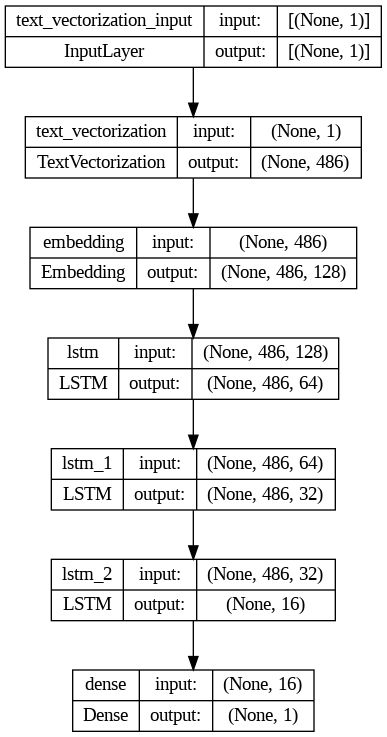

In [ ]:
# Visualisasi struktur Sequential API
tf.keras.utils.plot_model(model, show_shapes=True)

Dari struktur model, untuk input layernya berjumlah 1 karena menggunakan metode sequential. Selanjutnya untuk layer vectorization berjumlah 486 neuron berdasarkan panjang maksimal kalimat/document (486 token). Lalu pada layer embedding terdapat penambahan 128 berdasarkan jumlah elemen untuk mewakili nilai pada vektor. Kemudian pada layer LSTM di set neuronnya 64, 32, dan 16. Dan yang terakhir layer output neuronnya 1 untuk menghasilkan nilai probabilitas prediksi negatif dan positif (nilai 0 sampai 0.5 akan masuk ke class negatif, 0.51 sampai 1 masuk ke class positif).

### Model Training

In [ ]:
model_history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), callbacks=[callback])

Epoch 1/30
950/950 [==============================] - 135s 131ms/step - loss: 0.6933 - binary_accuracy: 0.5045 - auc: 0.4993 - val_loss: 0.6932 - val_binary_accuracy: 0.5000 - val_auc: 0.5000
Epoch 2/30
950/950 [==============================] - 55s 57ms/step - loss: 0.6932 - binary_accuracy: 0.4993 - auc: 0.4983 - val_loss: 0.6933 - val_binary_accuracy: 0.5000 - val_auc: 0.5001
Epoch 3/30
950/950 [==============================] - 52s 55ms/step - loss: 0.6933 - binary_accuracy: 0.4979 - auc: 0.4955 - val_loss: 0.6932 - val_binary_accuracy: 0.5000 - val_auc: 0.5000
Epoch 4/30
950/950 [==============================] - 48s 51ms/step - loss: 0.6932 - binary_accuracy: 0.4970 - auc: 0.4979 - val_loss: 0.6931 - val_binary_accuracy: 0.5000 - val_auc: 0.5000
Epoch 5/30
950/950 [==============================] - 48s 50ms/step - loss: 0.6932 - binary_accuracy: 0.4951 - auc: 0.4992 - val_loss: 0.6932 - val_binary_accuracy: 0.5000 - val_auc: 0.5001
Epoch 6/30
950/950 [============================

### Model Evaluation

In [ ]:
# Convert hasil training ke dataframe
history_df = pd.DataFrame(model_history.history)
history_df.head(10)

,loss,binary_accuracy,auc,val_loss,val_binary_accuracy,val_auc
0,0.693305,0.504539,0.499301,0.693173,0.5,0.500000
1,0.693223,0.499276,0.498336,0.693257,0.5,0.500132
2,0.693256,0.497895,0.495549,0.693164,0.5,0.500000
3,0.693219,0.496974,0.497895,0.693149,0.5,0.500000
4,0.693214,0.495132,0.499176,0.693160,0.5,0.500132
5,0.693250,0.501513,0.498167,0.693215,0.5,0.500000
6,0.693195,0.496842,0.500996,0.693150,0.5,0.500000
7,0.693189,0.500658,0.502521,0.693152,0.5,0.500000
8,0.693153,0.502632,0.501556,0.693245,0.5,0.500000
9,0.693138,0.503816,0.504310,0.693199,0.5,0.500000


Text(0, 0.5, 'auc')

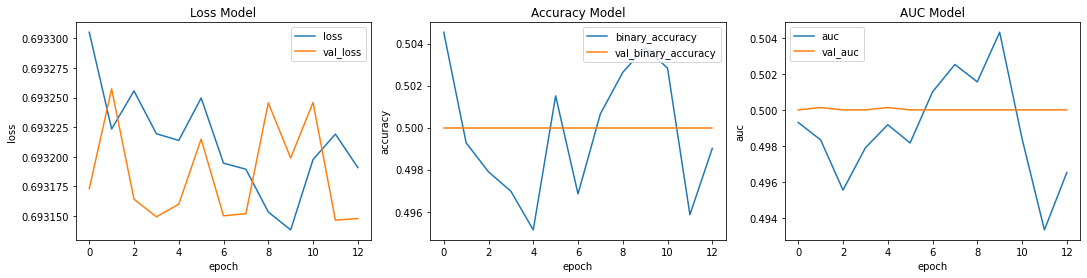

In [ ]:
# Plot hasil training
plt.figure(figsize=(18, 4))
plt.subplot(1, 3, 1)
sns.lineplot(data=history_df[["loss", "val_loss"]], dashes=False)
plt.title("Loss Model")
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(1, 3, 2)
sns.lineplot(data=history_df[["binary_accuracy", "val_binary_accuracy"]], dashes=False)
plt.title("Accuracy Model")
plt.xlabel("epoch")
plt.ylabel("accuracy")

plt.subplot(1, 3, 3)
sns.lineplot(data=history_df[["auc", "val_auc"]], dashes=False)
plt.title("AUC Model")
plt.xlabel("epoch")
plt.ylabel("auc")

Dari hasil training, performance model masih underfit. Karena untuk loss modelnya train dan validationnya masih terbilang tinggi yaitu diatas 0.5. Kemudian accuracy dan AUC scorenya train dan validationnya rata-rata 0.5. Training model berhenti pada epoch ke 13 karena loss model pada epoch tersebut tidak lagi turun (cenderung konstan atau naik).

In [ ]:
# Evaluasi Test-Set
y_pred = model.predict(X_test)
y_pred = np.where(y_pred >= 0.5, 1, 0)

print(classification_report(y_test, y_pred))

238/238 [==============================] - 5s 17ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      3800
           1       0.00      0.00      0.00      3800

    accuracy                           0.50      7600
   macro avg       0.25      0.50      0.33      7600
weighted avg       0.25      0.50      0.33      7600



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Hasil performansi model setelah dilakukan prediksi test set untuk akurasinya adalah 0.5. Lalu untuk precision dan recall pada sentimen negatif (0) memiliki nilai 0.5 dan 1. Kemudian untuk precision dan recall pada sentimen positif keduanya memiliki nilai 0. Artinya model benar-benar belum bisa memprediksi document yang bersentimen positif karena tidak ada prediksi yang benar terhadap document yang positif. Karena performance model masih belum baik, selanjutnya akan dilakukan improvisasi guna meningkatkan model yang telah dibuat.

### Model Improvement Definition

Pada model improvement ini adalah improvisasi dari model yang telah dibuat sebelumnya karena performancenya masih belum begitu baik. Di improvisasi akan dilakukan penambahan dropout layer dan batch normalization layer.

In [ ]:
# Clear session
os.environ["PYTHONHASHSEED"]=str(2)
tf.keras.backend.clear_session()
tf.random.set_seed(2)
np.random.seed(2)
random.seed(2)

# Membuat struktur model improvement
model_kai = Sequential()

# Vectorization layer
model_kai.add(text_vectorization)

# Embedding layer
model_kai.add(embedding)

# Hidden Layer
model_kai.add(LSTM(64, return_sequences=True))
model_kai.add(LSTM(32, return_sequences=True))
model_kai.add(LSTM(16))

# BatchNormalization layer
model_kai.add(BatchNormalization())

# Dropout layer
model_kai.add(Dropout(0.2))

# Output Layer
model_kai.add(Dense(1, activation="sigmoid"))

model_kai.compile(loss='binary_crossentropy',optimizer="adam", 
                  metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()])
model_kai.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 486)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 486, 128)          5530112   
                                                                 
 lstm (LSTM)                 (None, 486, 64)           49408     
                                                                 
 lstm_1 (LSTM)               (None, 486, 32)           12416     
                                                                 
 lstm_2 (LSTM)               (None, 16)                3136      
                                                                 
 batch_normalization (BatchN  (None, 16)               64        
 ormalization)                                          

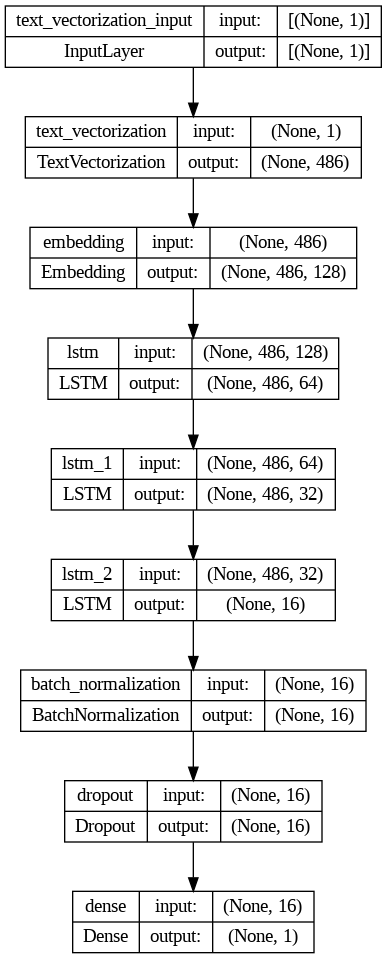

In [ ]:
# Visualisasi struktur model improvement
tf.keras.utils.plot_model(model_kai, show_shapes=True)

Untuk struktur model improvisasi berdasarkan model sebelumnya, kecuali terdapat penambahan dropout dan batch normalization.

### Model Improvement Training

In [ ]:
# Training model improvement
history_kai = model_kai.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
950/950 [==============================] - 97s 97ms/step - loss: 0.6944 - binary_accuracy: 0.5037 - auc: 0.5034 - val_loss: 3.3781 - val_binary_accuracy: 0.5000 - val_auc: 0.5000
Epoch 2/30
950/950 [==============================] - 51s 54ms/step - loss: 0.6935 - binary_accuracy: 0.5004 - auc: 0.4989 - val_loss: 0.6931 - val_binary_accuracy: 0.5001 - val_auc: 0.5003
Epoch 3/30
950/950 [==============================] - 61s 64ms/step - loss: 0.6934 - binary_accuracy: 0.4944 - auc: 0.4961 - val_loss: 0.6940 - val_binary_accuracy: 0.4999 - val_auc: 0.4997
Epoch 4/30
950/950 [==============================] - 51s 54ms/step - loss: 0.6934 - binary_accuracy: 0.4995 - auc: 0.4979 - val_loss: 0.7183 - val_binary_accuracy: 0.4999 - val_auc: 0.4999
Epoch 5/30
950/950 [==============================] - 46s 48ms/step - loss: 0.6933 - binary_accuracy: 0.4968 - auc: 0.4986 - val_loss: 0.6994 - val_binary_accuracy: 0.4999 - val_auc: 0.4997
Epoch 6/30
950/950 [==============================

### Model Improvement Evaluation

In [ ]:
# Convert hasil training ke dataframe
history_kai_df = pd.DataFrame(history_kai.history)
history_kai_df.head(10)

,loss,binary_accuracy,auc,val_loss,val_binary_accuracy,val_auc
0,0.694443,0.503717,0.503376,3.378121,0.500000,0.500000
1,0.693505,0.500428,0.498945,0.693102,0.500132,0.500263
2,0.693352,0.494441,0.496074,0.693964,0.499868,0.499737
3,0.693415,0.499474,0.497908,0.718338,0.499868,0.499868
4,0.693311,0.496842,0.498632,0.699422,0.499868,0.499737
5,0.693290,0.502434,0.498256,4.275737,0.500000,0.500132
6,0.693310,0.496250,0.497434,0.693114,0.500000,0.500000
7,0.693180,0.502401,0.503767,0.700255,0.500132,0.499868
8,0.692948,0.504046,0.506398,2.061081,0.500000,0.500000
9,0.693165,0.505592,0.504441,0.693227,0.500132,0.500132


Text(0, 0.5, 'auc')

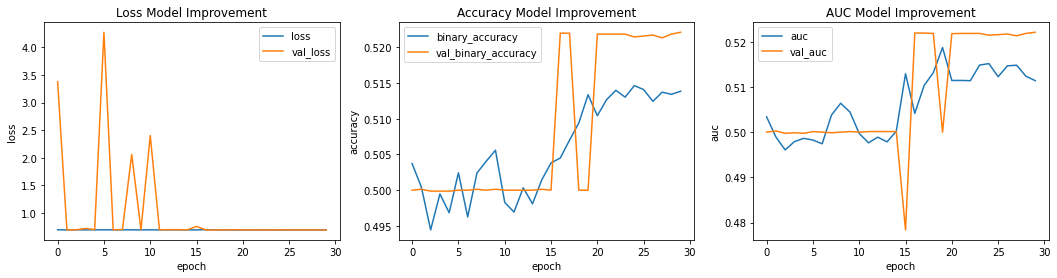

In [ ]:
# Plot hasil training
plt.figure(figsize=(18, 4))
plt.subplot(1, 3, 1)
sns.lineplot(data=history_kai_df[["loss", "val_loss"]], dashes=False)
plt.title("Loss Model Improvement")
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(1, 3, 2)
sns.lineplot(data=history_kai_df[["binary_accuracy", "val_binary_accuracy"]], dashes=False)
plt.title("Accuracy Model Improvement")
plt.xlabel("epoch")
plt.ylabel("accuracy")

plt.subplot(1, 3, 3)
sns.lineplot(data=history_kai_df[["auc", "val_auc"]], dashes=False)
plt.title("AUC Model Improvement")
plt.xlabel("epoch")
plt.ylabel("auc")

Dari hasil training, performance model masih terbilang underfit. Karena untuk loss modelnya train dan validationnya masih terbilang exploding dan tinggi yaitu diatas 0.5. Tetapi accuracy dan AUC scorenya memiliki sedikit kenaikan dibandingkan sebelumnya.

In [ ]:
# Evaluasi Test-Set
y_pred_kai = model_kai.predict(X_test)
y_pred_kai = np.where(y_pred_kai >= 0.5, 1, 0)

print(classification_report(y_test, y_pred_kai))

238/238 [==============================] - 6s 21ms/step
              precision    recall  f1-score   support

           0       0.52      0.68      0.59      3800
           1       0.53      0.36      0.43      3800

    accuracy                           0.52      7600
   macro avg       0.52      0.52      0.51      7600
weighted avg       0.52      0.52      0.51      7600



Hasil performansi model setelah dilakukan prediksi test set untuk akurasinya adalah 0.52. Dari hasil improvisasi terjadi sedikit penambahan performance dari sebelumnya (0.50). Selanjutnya akan dicoba improvisasi lagi pada model ini.

### Model Improvement 2 Definition

Model improvement selanjutnya adalah berdasarkan model improvisasi sebelumnya tetapi targetnya dicoba untuk di-encode menjadi one hot encoder. Kemudian untuk evaluasi yang digunakan menggunakan Categorical Accuracy karena untuk mengetahui akurasi dengan target yang berbentuk one hot encoder/kategorikal.

In [29]:
# Encode target menjadi kategorikal
y_train_encode = to_categorical(y_train)
y_test_encode = to_categorical(y_test)

In [30]:
# Clear session
os.environ["PYTHONHASHSEED"]=str(2)
tf.keras.backend.clear_session()
tf.random.set_seed(2)
np.random.seed(2)
random.seed(2)

# Membuat struktur model improvement
model_kai_ni = Sequential()

# Vectorization layer
model_kai_ni.add(text_vectorization)

# Embedding layer
model_kai_ni.add(embedding)

# Hidden Layer
model_kai_ni.add(LSTM(64, return_sequences=True))
model_kai_ni.add(LSTM(32, return_sequences=True))
model_kai_ni.add(LSTM(16))

# BatchNormalization layer
model_kai_ni.add(BatchNormalization())

# Dropout layer
model_kai_ni.add(Dropout(0.2))

# Output Layer
model_kai_ni.add(Dense(2, activation="softmax"))

model_kai_ni.compile(loss='categorical_crossentropy',optimizer="adam", 
                  metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.AUC()])
model_kai_ni.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 486)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 486, 128)          5530112   
                                                                 
 lstm (LSTM)                 (None, 486, 64)           49408     
                                                                 
 lstm_1 (LSTM)               (None, 486, 32)           12416     
                                                                 
 lstm_2 (LSTM)               (None, 16)                3136      
                                                                 
 batch_normalization (BatchN  (None, 16)               64        
 ormalization)                                          

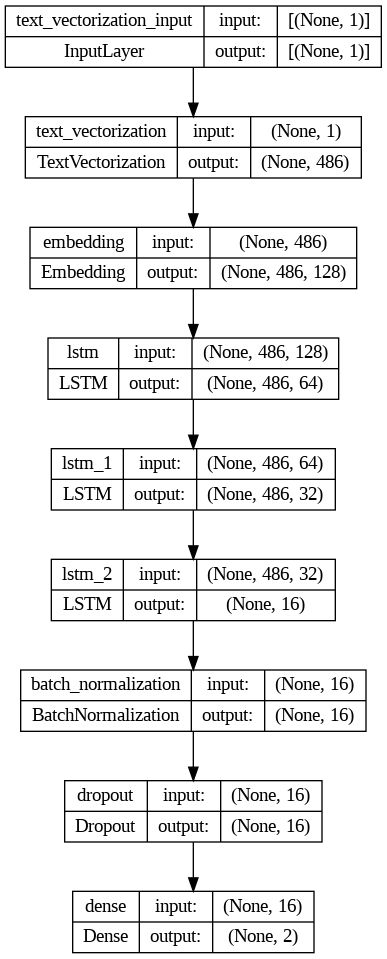

In [31]:
# Visualisasi struktur model improvement
tf.keras.utils.plot_model(model_kai_ni, show_shapes=True)

Untuk struktur modelnya sama seperti model sebelumnya tetapi layer output neuronnya 2 untuk menghasilkan 2 nilai probabilitas yaitu nilai prediksi negatif dan positif.

### Model Improvement 2 Training

In [32]:
# Training model improvement
history_kai_ni = model_kai_ni.fit(X_train, y_train_encode, epochs=30, validation_data=(X_test, y_test_encode))

Epoch 1/30
950/950 [==============================] - 139s 134ms/step - loss: 0.6934 - categorical_accuracy: 0.4997 - auc: 0.5028 - val_loss: 3.4261 - val_categorical_accuracy: 0.5000 - val_auc: 0.5000
Epoch 2/30
950/950 [==============================] - 62s 65ms/step - loss: 0.6933 - categorical_accuracy: 0.4993 - auc: 0.5006 - val_loss: 0.6931 - val_categorical_accuracy: 0.5000 - val_auc: 0.5001
Epoch 3/30
950/950 [==============================] - 55s 58ms/step - loss: 0.6934 - categorical_accuracy: 0.4964 - auc: 0.4970 - val_loss: 0.6931 - val_categorical_accuracy: 0.5001 - val_auc: 0.5003
Epoch 4/30
950/950 [==============================] - 52s 54ms/step - loss: 0.6933 - categorical_accuracy: 0.5003 - auc: 0.4972 - val_loss: 0.6937 - val_categorical_accuracy: 0.5001 - val_auc: 0.5002
Epoch 5/30
950/950 [==============================] - 55s 58ms/step - loss: 0.6933 - categorical_accuracy: 0.4993 - auc: 0.4963 - val_loss: 0.8164 - val_categorical_accuracy: 0.5000 - val_auc: 0.500

### Model Improvement 2 Evaluation

In [35]:
# Convert hasil training ke dataframe
history_kai_ni_df = pd.DataFrame(history_kai_ni.history)
history_kai_ni_df.head(10)

,loss,categorical_accuracy,auc,val_loss,val_categorical_accuracy,val_auc
0,0.693445,0.499671,0.502779,3.426053,0.500000,0.500000
1,0.693312,0.499276,0.500618,0.693140,0.500000,0.500132
2,0.693359,0.496414,0.497013,0.693074,0.500132,0.500329
3,0.693266,0.500296,0.497212,0.693715,0.500132,0.500197
4,0.693276,0.499342,0.496342,0.816419,0.500000,0.500066
5,0.693239,0.503849,0.500064,0.717656,0.500132,0.500197
6,0.693244,0.496776,0.496400,0.713186,0.500132,0.500197
7,0.693168,0.502303,0.504231,0.693133,0.500000,0.500066
8,0.693081,0.503553,0.504082,4.391159,0.500132,0.500066
9,0.693170,0.505099,0.504908,0.693702,0.499868,0.499803


Text(0, 0.5, 'auc')

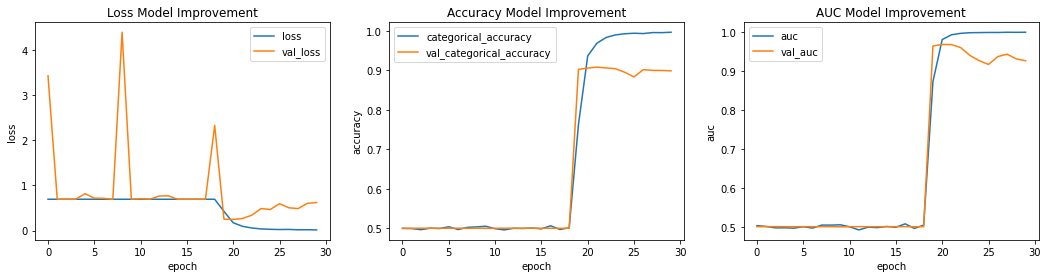

In [36]:
# Plot hasil training
plt.figure(figsize=(18, 4))
plt.subplot(1, 3, 1)
sns.lineplot(data=history_kai_ni_df[["loss", "val_loss"]], dashes=False)
plt.title("Loss Model Improvement")
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(1, 3, 2)
sns.lineplot(data=history_kai_ni_df[["categorical_accuracy", "val_categorical_accuracy"]], dashes=False)
plt.title("Accuracy Model Improvement")
plt.xlabel("epoch")
plt.ylabel("accuracy")

plt.subplot(1, 3, 3)
sns.lineplot(data=history_kai_ni_df[["auc", "val_auc"]], dashes=False)
plt.title("AUC Model Improvement")
plt.xlabel("epoch")
plt.ylabel("auc")

Dari hasil training, performance model sudah terbilang cukup baik dari sebelumnya. Dimana untuk loss-nya yang pada awal epoch sempat exploding tetapi sudah mulai konvergen ke 0 pada epoch sekitar 20. Kemudian untuk accuracy dan AUC performancenya sempat konstan di angka 0.5 tetapi terjadi kenaikan hinga 0.9 pada epoch ke 20 sampai seterusnya. Dari keseluruhan nilai performancenya model ini sebenarnya masih sedikit overfit.

In [37]:
# Evaluasi Test-Set
y_pred_kai_ni = model_kai_ni.predict(X_test)
y_pred_kai_ni = np.argmax(y_pred_kai_ni, axis=1)

print(classification_report(y_test, y_pred_kai_ni))

238/238 [==============================] - 6s 20ms/step
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      3800
           1       0.91      0.88      0.90      3800

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600



Dari hasil performance model setelah memprediksi test-set, akurasinya sudah jauh lebih baik (0.90) dibandingkan sebelumnya (0.52). Artinya model sudah baik untuk memprediksi document yang bersentimen positif maupun negatif.

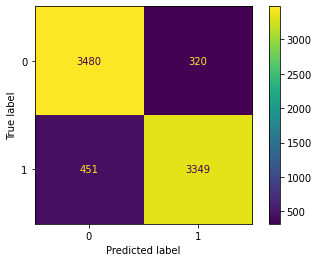

In [42]:
# Confusion matrix

cm = confusion_matrix(y_test, y_pred_kai_ni)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Berdasarkan confussion matrix, model ini lebih banyak melakukan kesalahan dalam memprediksi sentimen positif (451 data positif salah diprediksi) dibandingkan dengan sentimen negatif (320 data negatif salah diprediksi).

# vii. Model Saving

Pada tahap ini dilakukan saving model dari performance yang terbaik.

In [38]:
# Freeze Model
model_kai_ni.trainable = False
model_kai_ni.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 486)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 486, 128)          5530112   
                                                                 
 lstm (LSTM)                 (None, 486, 64)           49408     
                                                                 
 lstm_1 (LSTM)               (None, 486, 32)           12416     
                                                                 
 lstm_2 (LSTM)               (None, 16)                3136      
                                                                 
 batch_normalization (BatchN  (None, 16)               64        
 ormalization)                                          

In [39]:
# Save model
model_kai_ni.save("model_final")

# viii. Model Inference

NOTE : Percobaan menggunakan data inference dapat dilihat pada inference_set.ipynb

# ix. Kesimpulan

Untuk memprediksi sentimen positif dan negatif pada kasus ini dipengaruhi oleh sebuah kata (token) dalam document. Contohnya jika pada suatu document/teks terdapat kata/token seperti awesome, excellent, atau enjoy. Kemungkinan besar document tersebut diprediksi kedalam sentimen positif. Kemudian jika pada document/teks terdapat kata/token terrible, hard, atau away. Maka kemungkinan besar document tersebut diprediksi kedalam sentimen negatif.

Performansi model dapat dikatakan sudah cukup baik untuk memprediksi sentimen, tetapi masih belum sepenuhnya baik karena masih sedikit overfit. Maka untuk improvisasi selanjutnya perlu dilakukan training lagi dengan struktur model yang berbeda (pengaturan hidden layer, dropout, optimizer, dsb.) ataupun mencoba merubah teknik preprocessingnya sehingga diharapkan dapat meningkatkan lagi performance modelnya.

Beberapa hal yang mempengaruhi nilai performansi dari model NLP saat melakukan training dan prediksi adalah:
<ul>
    <li>Data imbalance. Umumnya model akan sulit untuk memprediksi data yang jumlah targetnya lebih sedikit dibandingkan dengan yang lebih banyak, biasanya dapat dihandle dengan metode Oversampling atau Undersampling.</li><br>
    <li>Teks preprocessing. Pemroresan teks pada teks processing dapat mempengaruhi akurasi dari sebuah model. Contohnya diperlukan tokenize agar karakter yang tidak bermakna tidak perlu dimasukkan ke model yang nantinya dapat memperburuk performansi model. Ataupun melakukan stemming/lemmatization untuk merubah kata menjadi kata dasarnya guna meningkatkan performansi model.</li><br>
    <li>Pembuatan struktur model. Metode perancangan RNN model dengan Simple RNN, LSTM, atau GRU dan dengan metode Sequential atau Functional juga mempengaruhi performansi model. Selain itu struktur dan pengaturan layer seperti input, hidden, dan output layer juga perlu dipertimbangkan karena termasuk sensitif terhadap performansi model.</li><br>
    <li>Improvisasi model yang dibuat. Hal ini dilakukan untuk meningkatkan lagi performance model yang telah dirancang, metode-nya dapat dilakukan penambahan drop layer, pengaturan activation pada layer, batch normalization, gradient cliping, optimization, dan sebagainnya.</li><br>
</ul>